<a href="https://colab.research.google.com/github/perrin-isir/tp_classif_images/blob/main/tp_classif_images.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>
<a id="raw-url" href="https://raw.githubusercontent.com/perrin-isir/tp_classif_images/main/tp_classif_images.ipynb" download> <img align="left" src="https://img.shields.io/badge/Github-Download%20(Right%20click%20%2B%20Save%20link%20as...)-blue" alt="Download (Right click + Save link as)" title="Download Notebook"></a>

**Ronan Houée - n° 21308445**

**IMPORTANT :** Ce notebook fonctionne mieux avec accélération GPU.  
Dans Colab : dans le menu Colab, choisissez Runtime > Change Runtime Type, puis sélectionnez 'GPU'.

In [ ]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
from PIL import ImageFile
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

learning_rate = 0.01
momentum = 0.5
batch_size_train = 40
batch_size_test = 500

In [ ]:
tmp_dir = os.path.join(os.path.expanduser("~"), "tmp_data")
# save dataset zip file in /root/tmp_data/, and unzip data
if not os.path.isfile(os.path.join(os.path.expanduser("~"), "tmp_data", "dataset.zip")):
    !mkdir {os.path.join(os.path.expanduser("~"), "tmp_data")}
    !wget -P {tmp_dir} -O {os.path.join(os.path.expanduser("~"), "tmp_data", "dataset.zip")} "https://filesender.renater.fr/download.php?token=c4814b83-d7fb-48df-9dec-0672109b65a0&files_ids=47151538"
    !unzip --qq -d {os.path.join(os.path.expanduser("~"), "tmp_data")} {os.path.join(os.path.expanduser("~"), "tmp_data", "dataset.zip")}

--2024-12-20 07:36:57--  https://filesender.renater.fr/download.php?token=c4814b83-d7fb-48df-9dec-0672109b65a0&files_ids=47151538
Resolving filesender.renater.fr (filesender.renater.fr)... 194.57.3.10
Connecting to filesender.renater.fr (filesender.renater.fr)|194.57.3.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262152450 (250M) [application/zip]
Saving to: ‘/root/tmp_data/dataset.zip’

dataset.zip         100%[===================>] 250.01M   386KB/s    in 11m 30s 

2024-12-20 07:48:28 (371 KB/s) - ‘/root/tmp_data/dataset.zip’ saved [262152450/262152450]



In [ ]:
# dataloader class and function

ImageFile.LOAD_TRUNCATED_IMAGES = True


class Data:
    def __init__(self, dataset_train, dataset_train_original, dataloader_train,
                 dataset_test, dataset_test_original, dataloader_test,
                 batch_size_train, batch_size_test):
        self.train = dataset_train
        self.train_original = dataset_train_original
        self.loader_train = dataloader_train
        self.num_train_samples = len(dataset_train)
        self.test = dataset_test
        self.test_original = dataset_test_original
        self.loader_test = dataloader_test
        self.num_test_samples = len(dataset_test)
        self.batch_size_train = batch_size_train
        self.batch_size_test = batch_size_test


def loadImgs(des_dir, img_size=100, batch_size_train=40, batch_size_test=100):

    dataset_train = dset.ImageFolder(root=os.path.join(des_dir, "train"),
                               transform=transforms.Compose([
                                   transforms.Resize(img_size),
                                   transforms.RandomCrop(75, padding=4),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x.to(device)),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                               ]))

    dataset_train_original = dset.ImageFolder(root=os.path.join(des_dir, "train"),
                               transform=transforms.Compose([
                                   transforms.Resize(img_size),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x.to(device)),
                               ]))

    dataset_test = dset.ImageFolder(root=os.path.join(des_dir, "test"),
                               transform=transforms.Compose([
                                   transforms.Resize(img_size),
                                   transforms.RandomCrop(75, padding=4),
                                   transforms.RandomHorizontalFlip(),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x.to(device)),
                                   transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                               ]))

    dataset_test_original = dset.ImageFolder(root=os.path.join(des_dir, "test"),
                               transform=transforms.Compose([
                                   transforms.Resize(img_size),
                                   transforms.ToTensor(),
                                   transforms.Lambda(lambda x: x.to(device)),
                               ]))

    dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True)

    dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_test, shuffle=True)

    data = Data(dataset_train, dataset_train_original, dataloader_train,
                dataset_test, dataset_test_original, dataloader_test,
                batch_size_train, batch_size_test)
    return data

In [ ]:
# plotting tool

def plotdata(data, indexes, model=None, original=True):
    l = []
    l_original = []
    for elt in indexes:
        t, _ = data.test[elt]
        l.append(t)
        tbis, _ = data.test_original[elt]
        l_original.append(tbis)
    cte = 30.0/9.0
    k = len(l)
    n = int(np.sqrt(cte * k))
    m = int(k/(n * 1.0))
    if (n*m<k):
        m = m+1
    width=20
    mult = 2
    if model is None:
        mult = 1
    fig, ax = plt.subplots(mult*m,n,squeeze=False, figsize=(width,int(width*m/(n*2.0))))
    for i in range(m):
        if model is not None:
            for j in range(n):
                if(j+n*i < k):
                    ax[mult*i+1,j].tick_params(axis=u'both', which=u'both',length=0)
                    ax[mult*i+1,j].set_ylim([-0.5,10.5])
                    ax[mult*i+1,j].set_xlim([-1.5,12.5])
                    ax[mult*i+1,j].set_xticks([])
                    ax[mult*i+1,j].set_xticks(np.arange(0.5,9.5,1), minor=True)
                    ax[mult*i+1,j].set_yticks([])
                    ax[mult*i+1,j].grid(False)
                    ax[mult*i+1,j].set_aspect('equal')
                    L = F.softmax(model(l[j+n*i]), dim=1).cpu().data.numpy().flatten()
                    C = [(0.9, 0.1, 0.0, 1.0), (0.0, 0.1, 0.9, 1.0)]
                    ax[mult*i+1,j].barh([1,5], [z * 10.0 for z in reversed(L)], color=C)
                    for idx in range(len(L)):
                        if L[idx]>0.02:
                            ax[mult*i+1,j].text(10.0*L[idx]+0.15,(len(L)-1-idx+0.1)*4.0,idx)
                else:
                    ax[mult*i+1,j].axis('off')
        # ------------------
        for j in range(n):
            if(j+n*i < k):
                ax[mult*i+0,j].tick_params(axis=u'both', which=u'both',length=0)
                ax[mult*i+0,j].set_xticks([])
                ax[mult*i+0,j].set_yticks([])
                ax[mult*i+0,j].grid(False)
                ax[mult*i+0,j].set_xticklabels([])
                ax[mult*i+0,j].set_yticklabels([])
                img = None
                if original:
                    img = l_original[j + n * i]
                else:
                    img = l[j + n * i]
                if img.shape[0] == 3:
                    N = img[:, :, :]
                    ax[mult * i + 0, j].imshow(N.permute(1, 2, 0).cpu().data.numpy(), )
                else:
                    N = img[0, :, :]
                    ax[mult*i+0,j].matshow(N.cpu().data.numpy(), cmap='Greys', )
            else:
                ax[mult*i+0,j].axis('off')
    return fig, ax

In [ ]:
# evaluation on a batch of test data:

def evaluate(model, data):
    batch_enum = enumerate(data.loader_test)
    batch_idx, (testdata, testtargets) = next(batch_enum)
    testdata = testdata.to(device)
    testtargets = testtargets.to(device)
    model = model.eval()
    oupt = torch.argmax(model(testdata), dim=1)

    youngs = np.argwhere(testtargets == 0)
    olds = np.argwhere(testtargets == 1)


    t = torch.sum(oupt == testtargets)
    result = t * 100.0 / len(testtargets)
    model = model.train()
    print(f"{t} correct on {len(testtargets)} ({result.item()} %)")
    return result.item()

In [ ]:
# iterative training on batches for one epoch:

def train_epoch(model, optimizer, data):
    batch_enum = enumerate(data.loader_train)
    i_count = 0
    iterations = data.num_train_samples // data.batch_size_train
    for batch_idx, (dt, targets) in batch_enum:
        i_count = i_count+1
        outputs = model(dt.to(device))
        loss = F.cross_entropy(outputs, targets.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if not i_count % 30:
            print(f"    batch {i_count} / {iterations}")
        if i_count == iterations:
            break

In [ ]:
# define the neural net

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.25)
        self.dropout3 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(((((75-2)//2-2)//2)**2)*64, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x.view(-1, 3, 75, 75)))
        x = self.dropout1(F.max_pool2d(x, 2))
        x = F.relu(self.conv2(x))
        x = self.dropout2(F.max_pool2d(x, 2))
        x = torch.flatten(x, 1)
        x = self.dropout3(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# load the data

data = loadImgs(os.path.join(os.path.expanduser("~"), "tmp_data"), batch_size_train=batch_size_train, batch_size_test=batch_size_test)

In [ ]:
# initialize the model

net = Net().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
# net.load_state_dict(torch.load(os.path.join(os.path.expanduser("~"), "tmp_data", "model_TP.pt")))


In [ ]:
# evaluate the model on one batch of test data (expecting ~50% accuracy after initialization)
evaluate(net, data)

266 correct on 500 (53.20000076293945 %)


53.20000076293945

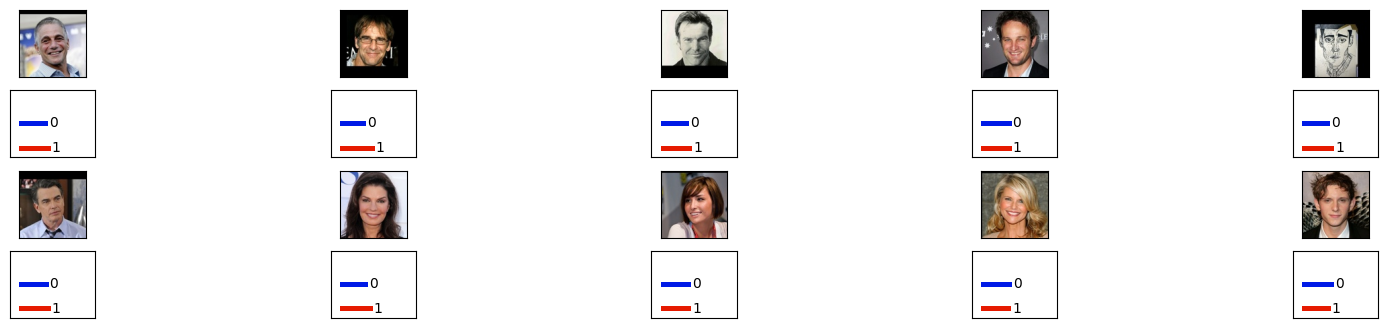

In [ ]:
# plot results on random images from the test set

indices = np.random.choice(range(data.num_test_samples), 10)
fig, ax = plotdata(data, indices, net, original=True)

In [ ]:
# train for one epoch, and save the model
num_epochs = 1
for j in range(num_epochs):
    print(f"epoch {j+1} / {num_epochs}")
    train_epoch(net, optimizer, data)
    evaluate(net, data)
    torch.save(net.state_dict(), os.path.join(os.path.expanduser("~"), "tmp_data", "model_TP.pt"))

epoch 1 / 1
    batch 30 / 1000
    batch 60 / 1000
    batch 90 / 1000
    batch 120 / 1000
    batch 150 / 1000
    batch 180 / 1000
    batch 210 / 1000
    batch 240 / 1000
    batch 270 / 1000
    batch 300 / 1000
    batch 330 / 1000
    batch 360 / 1000
    batch 390 / 1000
    batch 420 / 1000
    batch 450 / 1000
    batch 480 / 1000
    batch 510 / 1000
    batch 540 / 1000
    batch 570 / 1000
    batch 600 / 1000
    batch 630 / 1000
    batch 660 / 1000
    batch 690 / 1000
    batch 720 / 1000
    batch 750 / 1000
    batch 780 / 1000
    batch 810 / 1000
    batch 840 / 1000
    batch 870 / 1000
    batch 900 / 1000
    batch 930 / 1000
    batch 960 / 1000
    batch 990 / 1000
286 correct on 500 (57.20000457763672 %)


In [ ]:
# Question 2 - Performance non entrainé

res = []

it = 200

for i in range(it):
  res.append(evaluate(net, data))

print(res)
print(f"Score : {sum(res)/it}")


265 correct on 500 (53.000003814697266 %)
256 correct on 500 (51.20000076293945 %)
237 correct on 500 (47.400001525878906 %)
241 correct on 500 (48.20000076293945 %)
241 correct on 500 (48.20000076293945 %)
228 correct on 500 (45.60000228881836 %)
266 correct on 500 (53.20000076293945 %)
237 correct on 500 (47.400001525878906 %)
230 correct on 500 (46.000003814697266 %)
248 correct on 500 (49.60000228881836 %)
251 correct on 500 (50.20000076293945 %)
257 correct on 500 (51.400001525878906 %)
241 correct on 500 (48.20000076293945 %)
263 correct on 500 (52.60000228881836 %)
245 correct on 500 (49.000003814697266 %)
240 correct on 500 (48.000003814697266 %)
243 correct on 500 (48.60000228881836 %)
248 correct on 500 (49.60000228881836 %)
257 correct on 500 (51.400001525878906 %)
234 correct on 500 (46.80000305175781 %)
255 correct on 500 (51.000003814697266 %)
265 correct on 500 (53.000003814697266 %)
254 correct on 500 (50.80000305175781 %)
239 correct on 500 (47.80000305175781 %)
243 co

In [ ]:
import requests
import random

word_site = "https://www.mit.edu/~ecprice/wordlist.10000"


def getName(len):
  response = requests.get(word_site)
  WORDS = response.content.splitlines()

  name = ""
  for i in range(len):

    name = name + random.choice(WORDS).decode("utf-8")

  return name

In [ ]:
results = []
netname =  getName(3)

In [ ]:
# Question 3 - Courbe d'apprentissage

def tests():
  values = []
  for i in range(4):
    values.append(evaluate(net, data))

  return values

def courbe(num_epoch, new_model = False, factory_name = True):
  global net, results, netname, optimizer

  if new_model:

    net = Net().to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
    results = []
    results.append(tests())
    netname = getName(3)



  for i in range(num_epoch):
    train_epoch(net, optimizer, data)
    results.append(tests())



  if factory_name:
    torch.save(net.state_dict(), os.path.join(os.path.expanduser("~"), "tmp_data", "model_TP.pt"))
  else:
    torch.save(net.state_dict(), os.path.join(os.path.expanduser("~"), "tmp_data", "model_" + netname + ".pt"))



  fig = plt.figure()

  ax = fig.add_axes([0,0,1,1])
  ax.set_ylim([30, 80])

  plt.title("Pourcentage de bonnes réponses en fonction du numéro de l'epoch")

  bp = ax.violinplot(results)
  plt.show()


242 correct on 500 (48.400001525878906 %)
239 correct on 500 (47.80000305175781 %)
251 correct on 500 (50.20000076293945 %)
248 correct on 500 (49.60000228881836 %)
    batch 30 / 1000
    batch 60 / 1000
    batch 90 / 1000
    batch 120 / 1000
    batch 150 / 1000
    batch 180 / 1000
    batch 210 / 1000
    batch 240 / 1000
    batch 270 / 1000
    batch 300 / 1000
    batch 330 / 1000
    batch 360 / 1000
    batch 390 / 1000
    batch 420 / 1000
    batch 450 / 1000
    batch 480 / 1000
    batch 510 / 1000
    batch 540 / 1000
    batch 570 / 1000
    batch 600 / 1000
    batch 630 / 1000
    batch 660 / 1000
    batch 690 / 1000
    batch 720 / 1000
    batch 750 / 1000
    batch 780 / 1000
    batch 810 / 1000
    batch 840 / 1000
    batch 870 / 1000
    batch 900 / 1000
    batch 930 / 1000
    batch 960 / 1000
    batch 990 / 1000
296 correct on 500 (59.20000457763672 %)
289 correct on 500 (57.80000305175781 %)
299 correct on 500 (59.80000305175781 %)
302 correct on 500 (60

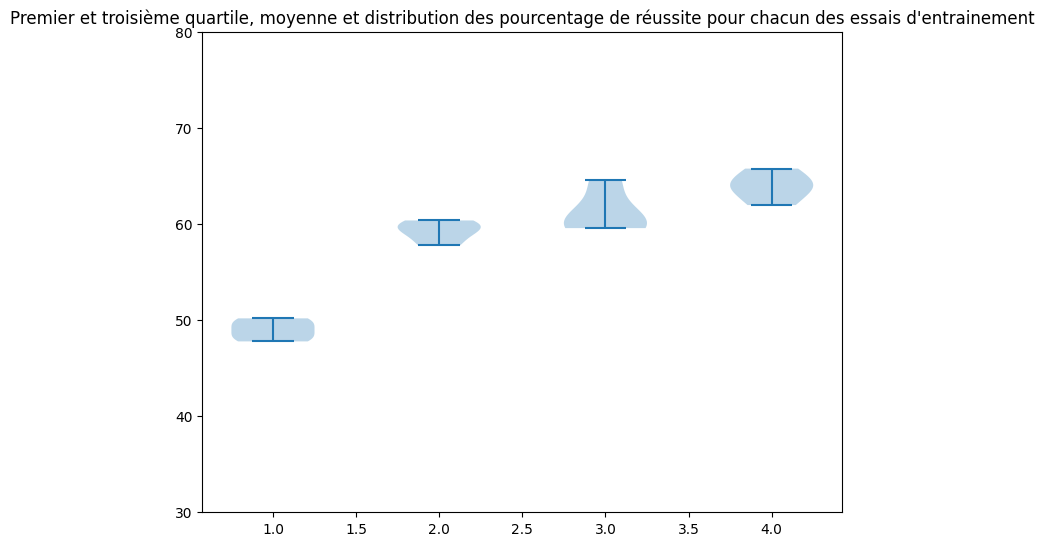

In [ ]:
# Pour reinitialiser le NN
courbe(3, True)

    batch 30 / 1000
    batch 60 / 1000
    batch 90 / 1000
    batch 120 / 1000
    batch 150 / 1000
    batch 180 / 1000
    batch 210 / 1000
    batch 240 / 1000
    batch 270 / 1000
    batch 300 / 1000
    batch 330 / 1000
    batch 360 / 1000
    batch 390 / 1000
    batch 420 / 1000
    batch 450 / 1000
    batch 480 / 1000
    batch 510 / 1000
    batch 540 / 1000
    batch 570 / 1000
    batch 600 / 1000
    batch 630 / 1000
    batch 660 / 1000
    batch 690 / 1000
    batch 720 / 1000
    batch 750 / 1000
    batch 780 / 1000
    batch 810 / 1000
    batch 840 / 1000
    batch 870 / 1000
    batch 900 / 1000
    batch 930 / 1000
    batch 960 / 1000
    batch 990 / 1000
338 correct on 500 (67.60000610351562 %)
325 correct on 500 (65.0 %)
310 correct on 500 (62.000003814697266 %)
315 correct on 500 (63.000003814697266 %)
    batch 30 / 1000
    batch 60 / 1000
    batch 90 / 1000
    batch 120 / 1000
    batch 150 / 1000
    batch 180 / 1000
    batch 210 / 1000
    batch 240

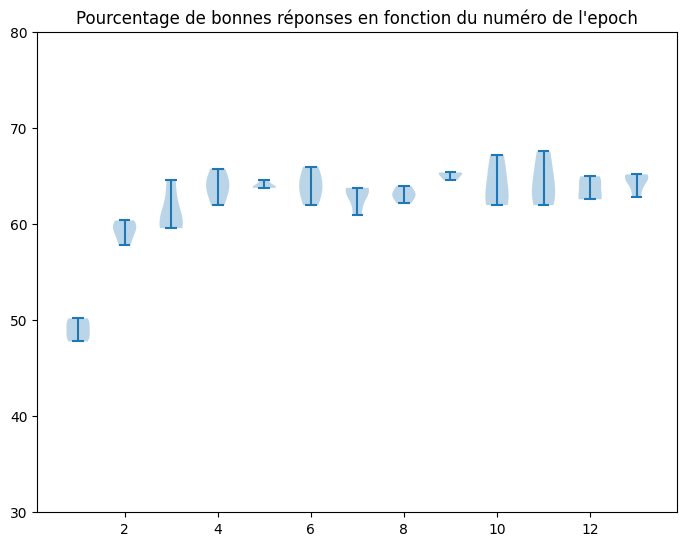

    batch 30 / 1000
    batch 60 / 1000
    batch 90 / 1000
    batch 120 / 1000
    batch 150 / 1000
    batch 180 / 1000
    batch 210 / 1000
    batch 240 / 1000
    batch 270 / 1000
    batch 300 / 1000
    batch 330 / 1000
    batch 360 / 1000
    batch 390 / 1000
    batch 420 / 1000
    batch 450 / 1000
    batch 480 / 1000
    batch 510 / 1000
    batch 540 / 1000
    batch 570 / 1000
    batch 600 / 1000
    batch 630 / 1000
    batch 660 / 1000
    batch 690 / 1000
    batch 720 / 1000
    batch 750 / 1000
    batch 780 / 1000
    batch 810 / 1000
    batch 840 / 1000
    batch 870 / 1000
    batch 900 / 1000
    batch 930 / 1000
    batch 960 / 1000
    batch 990 / 1000
318 correct on 500 (63.60000228881836 %)
316 correct on 500 (63.20000457763672 %)
312 correct on 500 (62.400001525878906 %)
321 correct on 500 (64.20000457763672 %)
    batch 30 / 1000
    batch 60 / 1000
    batch 90 / 1000
    batch 120 / 1000
    batch 150 / 1000
    batch 180 / 1000
    batch 210 / 1000
 

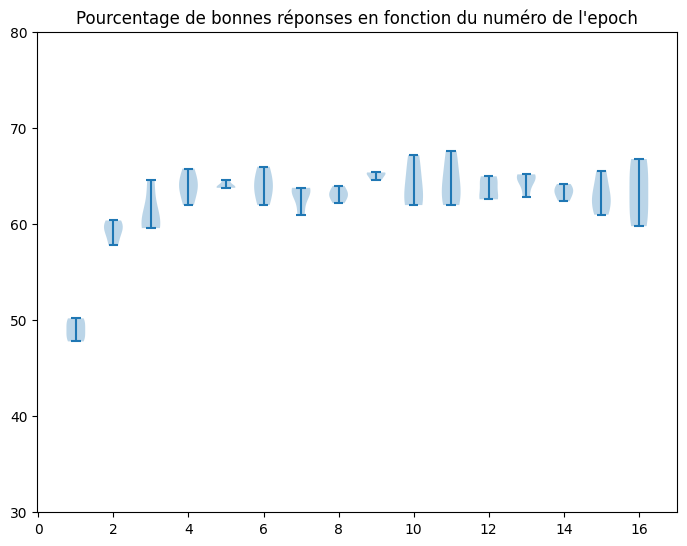

In [ ]:
# A executer plusieurs fois pour l'entrainer
for i in range(2):
  courbe(3, False)

In [ ]:
#Question 5 - Nouvelle manière d'évaluer

import statistics
from itertools import repeat
import matplotlib.patches as mpatches

def evaluate_best(model, data):
    batch_enum = enumerate(data.loader_test)
    batch_idx, (testdata, testtargets) = next(batch_enum)
    testdata = testdata.to(device)
    testtargets = testtargets.to(device)
    model = model.eval()

    oupt = torch.argmax(model(testdata), dim=1)
    values = model(testdata)


    soft = nn.Softmax(dim=1)
    probas = soft(model(testdata))

    zeros = []
    ones = []

    for i in range(len(oupt)):
      if oupt[i] == 0:
        zeros.append(probas[i][0].item())
      else:
        ones.append(probas[i][1].item())

    t = torch.sum(oupt == testtargets)
    result = t * 100.0 / len(testtargets)
    model = model.train()
    print(f"{t} correct on {len(testtargets)} ({result.item()} %)")



    fig = plt.figure()

    ax = fig.add_axes([0,0,1,1])
    ax.set_ylim([0, 1])

    label = ["Classe 0", "Classe 1"]

    red_patch = mpatches.Patch(color='red')
    blue_patch = mpatches.Patch(color='blue')
    fig.suptitle('Confiance des prédictions par classe', fontsize=16)

    pos   = [1, 2, 4, 5, 7, 8]
    fake_handles = [red_patch, blue_patch]
    bp = ax.violinplot([zeros, ones])

    bp["bodies"][0].set_facecolor('red')
    bp["bodies"][1].set_facecolor('blue')


    ax.legend(fake_handles, label)
    plt.show()

    print(f"Classe 0 : moyenne = {statistics.mean(zeros)} variance = {statistics.stdev(zeros)}")
    print(f"Classe 1 : moyenne = {statistics.mean(ones)} variance = {statistics.stdev(ones)}")


    return result.item()

314 correct on 500 (62.80000305175781 %)


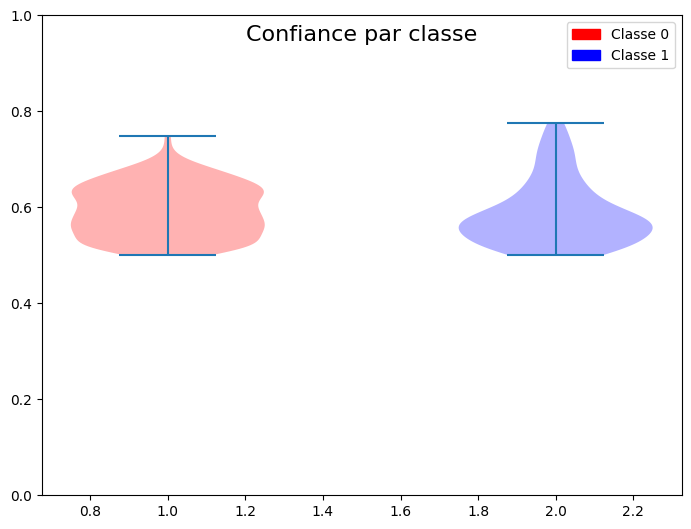

Classe 0 : moyenne = 0.5932897059422619 variance = 0.054705846998504754
Classe 1 : moyenne = 0.5871346307979836 variance = 0.0673141865678387


62.80000305175781

In [ ]:
evaluate_best(net, data)

In [ ]:
#Question 9 - Images bien ou mal classifiées et niveau de confiance
# Pas terminée, l'environnement d'exécution s'étant expiré et impossible d'executer en mode GPU une copie.


def evaluate_conf(model, data):
    batch_enum = enumerate(data.loader_test)
    batch_idx, (testdata, testtargets) = next(batch_enum)
    testdata = testdata.to(device)
    testtargets = testtargets.to(device)
    model = model.eval()

    oupt = torch.argmax(model(testdata), dim=1)
    values = model(testdata)


    soft = nn.Softmax(dim=1)
    probas = soft(model(testdata))

    zeros = []
    ones = []

    for i in range(len(oupt)):
      if oupt[i] == 0:
        zeros.append(probas[i][0].item())
      else:
        ones.append(probas[i][1].item())

    mask = torch.where(oupt != testtargets)

    print(mask)


evaluate_conf(net, data)

NameError: name 'net' is not defined

**Question 1**:


Structure reseau :

 Le reseau est composé de deux couches de convolution, et trois couches linéaires.

 Les couches de convolution

 Les couches linéaires


Nb params :



**Question 2**:

Performance d'un reseau non entrainé :

200 essais réalisés pour calculer un score moyen (voir cellule Question2) pour un réseau juste initialisé

Résultat : Sur 200 essais, la moyenne est de 50.280002212524415 %

Un réseau non-entrainé n'est donc pas meilleur qu'un choix aléatoire.

**Question 6**:

Liste des hyperparmatères :
  - num_epoch d'entrainement ---> si les autres paramètres sont bien ajustés, plus il est élevé et meilleure seront les performances après entrainement.

  - les datasets d'images utilisés ---> si les images d'entrainement sont trop similaires/pas assez nombreuses/... , l'entrainement pourrait ne pas être fructueux pour une évaluation sur un dataset différent.
  De même, si les images d'évaluation sont les mêmes que lors de l''entrainement, on aura une évaluation biasée.
  
  - le crop ---> pour garantir une certaine diversité dans les images utilisées, on utilise ce crop aléatoire. Le format après crop est un hyperparamètre qui jouera sur la diversité des images en entrée (voir point précédent)

  - Le learning rate --->

  - La forme de reseau utilisée -->

  - Les différents dropouts -->

**Question 7**:

RandomCrop modifie la structure de l'image pour la modifier vers une taille de 75 * 75.

Cela permet d'éviter de toujours avoir le visage centré, et donc de s'entrainer dans des contextes plus variés pour avoir un réseau plus efficaces faces à des images différentes.

**Question 9**

On posséde grâce  la question 5 la probabilité que le réseau accorde à chacune des deux classes pour chaque image : autrement dit son niveau de confiance dans sa prédiction.

On peut facilement récupérer les indices des images pour lesquelles il s'est trompé, et sélectionner celle avec la plus haute confiance. De même pour celle bien classifiée.



**Question 11**

CycleGan permet de transformer l'image en la modifiant légèrement avec de l'apprentissae non-supervisé.

Pour rajeunir ou viellir artificiellement un visage, on pourrait utiliser plusieurs modèle pour passer vers des tranches d'ages spécifiques.

Chaque modèle serait entrainé pour avec deux catégories d'images de 10 ans de différence, et entrainerait les générateurs  à passer d'une catégorie a l'autre.